<a href="https://colab.research.google.com/github/Dhakal33/ML-Modeling-of-Nitrate-Phosphorus-Concentration/blob/main/Phosphorus_Modeling_in_Cuyahoga_Watershed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Prediction of Phosphorus Concentrations Using Machine Learning Algorithms in Cuyahoga Watershed**

*Please refer to this publication to learn more about this study.*

Bhattarai, A., Dhakal, S., Gautam, Y., & Bhattarai, R. (2021). Prediction of nitrate and phosphorus concentrations using machine learning algorithms in watersheds with different landuse. Water, 13(21), 3096. DOI: https://doi.org/10.3390/w13213096

In [6]:
# Import phosphorus concentration dataset
from google.colab import files
uploaded = files.upload()

Saving Phosphorus_Modeling.xlsx to Phosphorus_Modeling.xlsx


In [3]:
!pip install bayesian-optimization scikit-learn pandas

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime

In [4]:
# Import machine learning models and bayesian optimization module
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from bayes_opt import BayesianOptimization

In [7]:
# Read excel file as pandas dataframe
df = pd.read_excel("Phosphorus_Modeling.xlsx")
df.head()

,Date,Flow,Total Suspended Solids,Total Phosphorus
0,1981-11-04,331.0,12.3,0.431
1,1981-11-05,353.0,8.9,0.373
2,1981-11-06,821.0,181.0,0.800
3,1981-11-07,733.0,36.9,0.340
4,1981-11-08,603.0,31.3,0.285


In [8]:
# Feature Engineering - To extract the Months from the 'Date' column
df['Month'] = df['Date'].apply(lambda date:date.month)
df.head()

,Date,Flow,Total Suspended Solids,Total Phosphorus,Month
0,1981-11-04,331.0,12.3,0.431,11
1,1981-11-05,353.0,8.9,0.373,11
2,1981-11-06,821.0,181.0,0.800,11
3,1981-11-07,733.0,36.9,0.340,11
4,1981-11-08,603.0,31.3,0.285,11


In [9]:
# Dropping missing values rows
df.dropna(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11996 entries, 0 to 11995
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    11996 non-null  datetime64[ns]
 1   Flow                    11996 non-null  float64       
 2   Total Suspended Solids  11996 non-null  float64       
 3   Total Phosphorus        11996 non-null  float64       
 4   Month                   11996 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 468.7 KB


In [11]:
# features_considered=['Flow','Month','Total Suspended Solids','Total Phosphorus']
# df = df[features_considered]
df.index = df['Date']
df = df.drop('Date', axis=1)
df.head()

,Flow,Total Suspended Solids,Total Phosphorus,Month
Date,,,,
1981-11-04,331.0,12.3,0.431,11
1981-11-05,353.0,8.9,0.373,11
1981-11-06,821.0,181.0,0.800,11
1981-11-07,733.0,36.9,0.340,11
1981-11-08,603.0,31.3,0.285,11


### **Create labels and features for ML algorithms**

In [12]:
# Create labels for "Total Phosphorus" concentration
labels = np.array(df['Total Phosphorus'])

# Remove the labels from the features
# axis 1 refers to the columns
features = df.drop('Total Phosphorus', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

### **Split the dataset into train and test set (70:30)**

In [13]:
# Using Skicit-learn to split data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [14]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (8397, 3)
Training Labels Shape: (8397,)
Testing Features Shape: (3599, 3)
Testing Labels Shape: (3599,)


# **Random Forest Regressor**

In [47]:
# Define objective function with hyperparameters for Random Forest
def objective(n_estimators, max_depth, min_samples_split, max_features):
    model = RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  max_features=min(max_features, 0.999),  # Fraction, must be <= 1.0
                                  random_state=123)

    return -1.0 * cross_val_score(model, train_features, train_labels, cv=3, scoring="neg_mean_squared_error").mean()

In [48]:
# Bounds for hyperparameters
param_bounds = {
    'n_estimators': (50, 1000),
    'max_depth': (25, 50),
    'min_samples_split': (2, 25),
    'max_features': (0.1, 0.999),
}

In [49]:
optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=123)
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.01351   | 42.41     | 0.3572    | 7.218     | 573.7     |
| 2         | 0.01347   | 42.99     | 0.4804    | 24.56     | 700.6     |
| 3         | 0.01339   | 37.02     | 0.4525    | 9.893     | 742.6     |
| 4         | 0.0134    | 35.96     | 0.1537    | 11.16     | 751.1     |
| 5         | 0.0134    | 29.56     | 0.2577    | 14.23     | 555.2     |
| 6         | 0.01375   | 44.63     | 0.8474    | 3.901     | 584.3     |
| 7         | 0.01387   | 49.36     | 0.9217    | 2.393     | 590.2     |
| 8         | 0.01375   | 46.03     | 0.886     | 3.899     | 608.6     |
| 9         | 0.01298   | 46.82     | 0.7953    | 23.8      | 600.3     |
| 10        | 0.01385   | 34.92     | 0.8067    | 2.241     | 597.6     |
| 11        | 0.0139    | 25.86     | 0.1386    | 2.189     | 628.0     |
| 12        | 0.01377   | 26.23     | 

In [50]:
best_params = optimizer.max['params']
best_params

{'max_depth': 33.75993741548603,
 'max_features': 0.6420242829612058,
 'min_samples_split': 2.7080669670546724,
 'n_estimators': 624.4399442932119}

In [51]:
final_model = RandomForestRegressor(n_estimators=int(best_params['n_estimators']),
                                   max_depth=int(best_params['max_depth']),
                                   min_samples_split=int(best_params['min_samples_split']),
                                   max_features=best_params['max_features'],
                                   random_state=42)
final_model.fit(train_features, train_labels)
score = final_model.score(test_features, test_labels)
print(f"Test R^2 Score: {score}")

Test R^2 Score: 0.5876917401923504


In [52]:
best_params_formatted = {
    'n_estimators': int(best_params['n_estimators']),
    'max_depth': int(best_params['max_depth']),
    'min_samples_split': int(best_params['min_samples_split']),
    'max_features': best_params['max_features']
}
best_params_formatted

{'n_estimators': 624,
 'max_depth': 33,
 'min_samples_split': 2,
 'max_features': 0.6420242829612058}

In [53]:
# Use the forest's predict method on the test data
predictions = final_model.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.07 degrees.


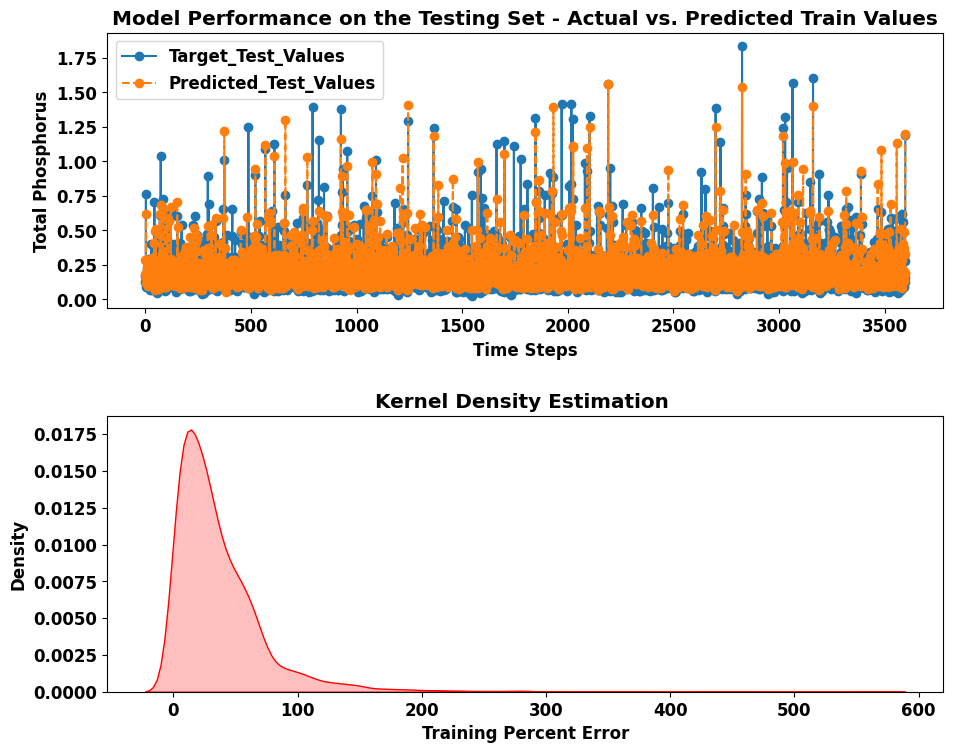

In [54]:
#'Model Performance on the training set - Actual vs. Predicted Values'
fig,axs=plt.subplots(2,1,figsize=(10,8))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=12

axs[0].plot(test_labels,marker='o',linestyle='-',label='Target_Test_Values')

axs[0].plot(predictions,marker='o',linestyle='dashed',label='Predicted_Test_Values')
axs[0].set_title('Model Performance on the Testing Set - Actual vs. Predicted Train Values',fontweight='bold')
axs[0].legend()
axs[0].set_xlabel('Time Steps',fontweight='bold')
axs[0].set_ylabel('Total Phosphorus',fontweight='bold');

# Training percent error distribution plot
train_err=abs((test_labels-predictions)/test_labels)*100
train_err=pd.DataFrame(train_err,columns=['Training Error'])

sns.kdeplot(train_err['Training Error'],fill=True,color='r',ax=axs[1])
axs[1].set_xlabel('Training Percent Error',fontweight='bold')
axs[1].set_ylabel('Density',fontweight='bold');
axs[1].set_title('Kernel Density Estimation ',fontweight='bold')
for ax in axs.flat:
    ax.figure.tight_layout(pad=2);

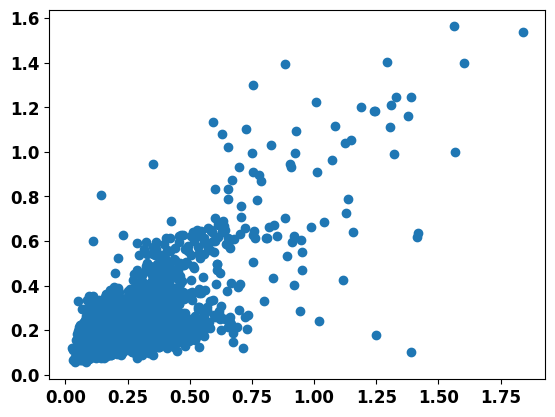

In [55]:
plt.scatter(test_labels,predictions)

### **Decision Tree - Sample**

In [56]:
## Test code only
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

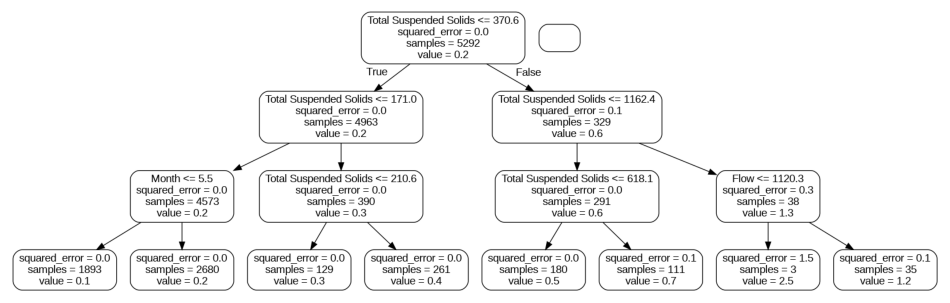

In [57]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))

# Remove the axes
ax.axis('off')

plt.imshow(plt.imread('small_tree.png'))

### **Feature Importance**

In [58]:
# Get numerical feature importances
importances = list(final_model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Total Suspended Solids Importance: 0.68
Variable: Flow                 Importance: 0.25
Variable: Month                Importance: 0.07


### **Evaluation Metrics**

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test_labels,predictions)
mae = mean_absolute_error(test_labels,predictions)
r2_score = r2_score(test_labels,predictions)
print("Random Forest Regressor")
print(f"MSE: {mse: .5f}")
print(f"MAE: {mae: .5f}")
print(f"R^2 value: {r2_score: .3f}")

Random Forest Regressor
MSE:  0.01159
MAE:  0.06877
R^2 value:  0.588


# **Support Vector Regressor**

In [36]:
# Define the objective function to optimize.
def svr_objective(C):
    model = SVR(C = C)
    model.fit(train_features, train_labels)
    f = -1.0 * cross_val_score(model, train_features, train_labels, cv=3, scoring="neg_mean_squared_error").mean()
    return f

In [37]:
svr_param_bounds = {'C': (1, 1000)}

In [38]:
# Create a BayesianOptimization optimizer and optimize the svr_objective function.
optimizer = BayesianOptimization(f = svr_objective,
                                 pbounds = svr_param_bounds, verbose = 2, allow_duplicate_points=True,
                                 random_state = 123)
optimizer.maximize(init_points = 5, n_iter = 15)

|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.02246   | 696.8     |
| 2         | 0.01833   | 286.9     |
| 3         | 0.018     | 227.6     |
| 4         | 0.02106   | 551.8     |
| 5         | 0.02262   | 719.7     |
| 6         | 0.02451   | 999.9     |
| 7         | 0.0245    | 998.8     |
| 8         | 0.02453   | 999.8     |
| 9         | 0.02254   | 709.3     |
| 10        | 0.02269   | 729.7     |
| 11        | 0.02454   | 999.9     |
| 12        | 0.02451   | 997.8     |
| 13        | 0.0245    | 997.0     |
| 14        | 0.02449   | 996.0     |
| 15        | 0.02447   | 999.6     |
| 16        | 0.02452   | 995.0     |
| 17        | 0.02445   | 994.1     |
| 18        | 0.02447   | 993.1     |
| 19        | 0.02445   | 992.2     |
| 20        | 0.02445   | 991.3     |


In [39]:
best_params = optimizer.max['params']
best_params

{'C': 999.9143255745204}

In [40]:
svr_final_model = SVR(C=best_params['C'])
svr_final_model.fit(train_features, train_labels)
svr_score = svr_final_model.score(test_features, test_labels)
print(f"Test R^2 Score: {svr_score}")

Test R^2 Score: 0.5621499746154126


In [41]:
# Use the SVR's predict method on the test data
SVR_predictions = svr_final_model.predict(test_features)

# Calculate the absolute errors
SVR_errors = abs(SVR_predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(SVR_errors), 2), 'degrees.')

Mean Absolute Error: 0.08 degrees.


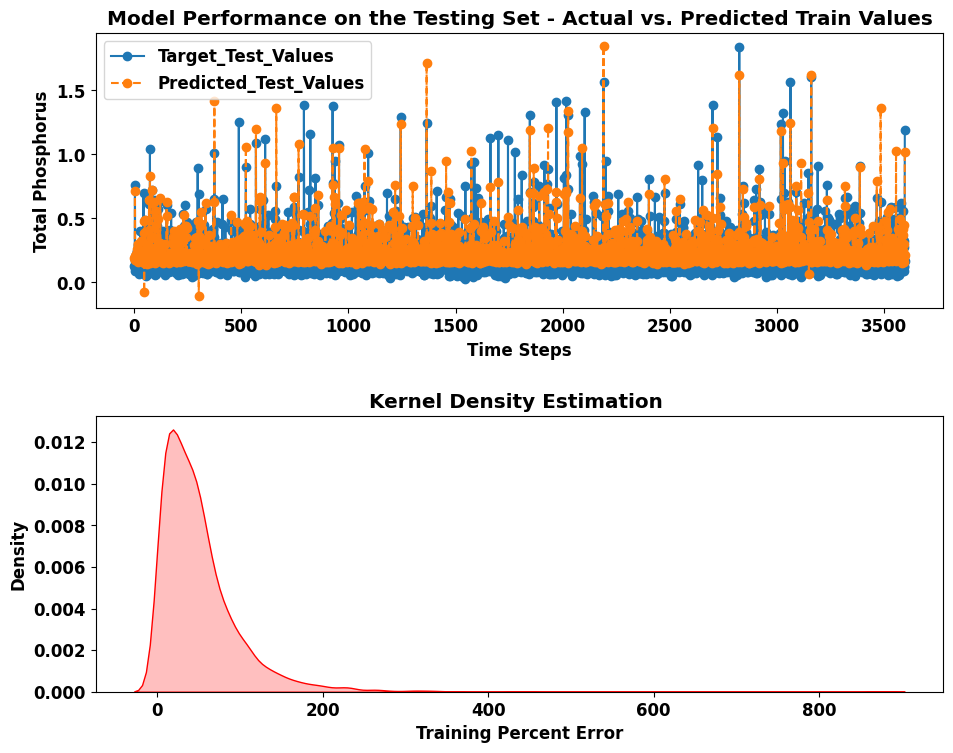

In [44]:
#'Model Performance on the training set - Actual vs. Predicted Values'
fig,axs=plt.subplots(2,1,figsize=(10,8))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=12

axs[0].plot(test_labels,marker='o',linestyle='-',label='Target_Test_Values')

axs[0].plot(SVR_predictions,marker='o',linestyle='dashed',label='Predicted_Test_Values')
axs[0].set_title('Model Performance on the Testing Set - Actual vs. Predicted Train Values',fontweight='bold')
axs[0].legend()
axs[0].set_xlabel('Time Steps',fontweight='bold')
axs[0].set_ylabel('Total Phosphorus',fontweight='bold');

# Training percent error distribution plot
train_err=abs((test_labels-SVR_predictions)/test_labels)*100
train_err=pd.DataFrame(train_err,columns=['Training Error'])

sns.kdeplot(train_err['Training Error'],fill=True,color='r',ax=axs[1])
axs[1].set_xlabel('Training Percent Error',fontweight='bold')
axs[1].set_ylabel('Density',fontweight='bold');
axs[1].set_title('Kernel Density Estimation ',fontweight='bold')
for ax in axs.flat:
    ax.figure.tight_layout(pad=2);

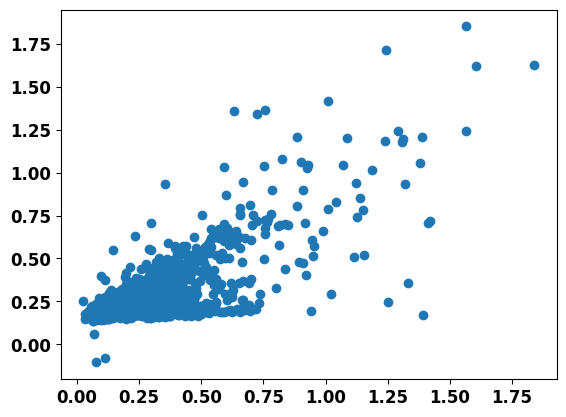

In [45]:
plt.scatter(test_labels,SVR_predictions)

### **Evaluation Metrics**

In [46]:
mse = mean_squared_error(test_labels,SVR_predictions)
mae = mean_absolute_error(test_labels,SVR_predictions)
r2_score = r2_score(test_labels,SVR_predictions)
print("Support Vector Regressor")
print(f"MSE: {mse: .5f}")
print(f"MAE: {mae: .5f}")
print(f"R^2 value: {r2_score: .3f}")

Support Vector Regressor
MSE:  0.01231
MAE:  0.07940
R^2 value:  0.562
